# Goal

* making a correlation network of l2fc values across days & substrates
* only keeping edges above a certain correlation coef cutoff

# Setting variables

In [1]:
import os
%load_ext rpy2.ipython
%load_ext pushnote

In [2]:
%%R
workDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/l2fc_heavy_window/l2fc_corr_network/'
figDir = '/home/nick/notebook/fullCyc/figures/incorporators/l2fc_corr_network/'

# log2 fold change
l2fcResDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/l2fc_heavy_window/'
l2fcResFile = file.path(l2fcResDir, 'l2fc_sparse-maxRejH.txt')

# params
padj.cutoff = 0.05   # adjusted p-value cutoff for selecting incorporators
nprocs = 24

# Init

In [3]:
%Rpull workDir
workDir = workDir[0]
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
%cd $workDir    

/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7rs/incorporators/l2fc_heavy_window/l2fc_corr_network


In [4]:
%%R
#library(phyloseq)
library(dplyr)
library(tidyr)
library(ggplot2)
#library(network)
library(igraph)
library(cluster)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘igraph’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:tidyr’:

    %>%, crossing


 

# Loading files

In [5]:
%%R 
# log2 fold change analysis results file
df.l2fc = read.delim(l2fcResFile, sep='\t') %>%
    mutate(Rank2 = gsub('^__', '', Rank2),
           Rank3 = gsub('^__', '', Rank3),
           Rank4 = gsub('^__', '', Rank4),
           Rank5 = gsub('^__', '', Rank5),
           Rank6 = gsub('^__', '', Rank6),
           Rank7 = gsub('^__', '', Rank7))
df.l2fc %>% head(n=3)

  Substrate Day Microcosm_replicate sparsity_threshold      OTU log2FoldChange
1   13C-Ami   1                   2               0.25  OTU.514    -0.67802374
2   13C-Ami   1                   2               0.25  OTU.816    -0.06751225
3   13C-Ami   1                   2               0.25 OTU.1099    -0.01965210
          p padj    Rank1          Rank2               Rank3
1 0.9999869    1 Bacteria Proteobacteria Deltaproteobacteria
2 0.9839460    1 Bacteria Proteobacteria Deltaproteobacteria
3 0.9867221    1 Bacteria  Acidobacteria               32-21
                 Rank4          Rank5      Rank6                Rank7 Rank8
1    Desulfobacterales Nitrospinaceae uncultured uncultured_bacterium  <NA>
2    Desulfobacterales Nitrospinaceae uncultured uncultured_bacterium  <NA>
3 uncultured_bacterium           <NA>       <NA>                 <NA>  <NA>


# Selecting incorporators

In [6]:
%%R

df.inc = df.l2fc %>%
    filter(padj < padj.cutoff)

cat('Total number of incorporator OTUs:', df.inc$OTU %>% unique %>% length, '\n')

Total number of incorporator OTUs: 418 


In [7]:
%%R
df.l2fc = df.l2fc %>% 
    mutate(Incorporator = (padj < padj.cutoff) %>% as.numeric) 
df.l2fc %>% head(n=3)

  Substrate Day Microcosm_replicate sparsity_threshold      OTU log2FoldChange
1   13C-Ami   1                   2               0.25  OTU.514    -0.67802374
2   13C-Ami   1                   2               0.25  OTU.816    -0.06751225
3   13C-Ami   1                   2               0.25 OTU.1099    -0.01965210
          p padj    Rank1          Rank2               Rank3
1 0.9999869    1 Bacteria Proteobacteria Deltaproteobacteria
2 0.9839460    1 Bacteria Proteobacteria Deltaproteobacteria
3 0.9867221    1 Bacteria  Acidobacteria               32-21
                 Rank4          Rank5      Rank6                Rank7 Rank8
1    Desulfobacterales Nitrospinaceae uncultured uncultured_bacterium  <NA>
2    Desulfobacterales Nitrospinaceae uncultured uncultured_bacterium  <NA>
3 uncultured_bacterium           <NA>       <NA>                 <NA>  <NA>
  Incorporator
1            0
2            0
3            0


# l2fc matrix

In [941]:
%%R 
# selecting all incorporator OTUs, keeping l2fc values for all substrates/days

cat('Total number of incorporator OTUs:', df.inc$OTU %>% unique %>% length, '\n')

df.l2fc.w = df.l2fc %>%
    filter(OTU %in% df.inc$OTU) %>%
    mutate(Day = gsub('^', 'D', Day)) %>%
    unite(Substrate_Day, Substrate, Day, sep='_') %>%
    dplyr::select(OTU, Substrate_Day, log2FoldChange) %>%
    spread(Substrate_Day, log2FoldChange, fill=0) 
rownames(df.l2fc.w) = df.l2fc.w$OTU
df.l2fc.w$OTU = NULL

df.l2fc.w %>% nrow %>% print
df.l2fc.w %>% head(n=3)

Total number of incorporator OTUs: 418 
[1] 418
           13C-Ami_D1 13C-Ami_D14 13C-Ami_D3 13C-Ami_D6 13C-Cel_D14 13C-Cel_D3
OTU.1     -0.01820865   0.1739515 -0.3314178 -0.6235129 -0.54059364 -0.2302009
OTU.10019  0.61441986  -0.2550232  0.2052660 -0.9731104  3.90597961  0.8263626
OTU.1002   0.00000000  -1.0709669  0.0000000  0.0000000  0.03407083  0.0000000
          13C-Cel_D30 13C-Cel_D48 13C-Cel_D6 13C-Glu_D1 13C-Glu_D14 13C-Glu_D3
OTU.1       0.1457742   0.3395559 -0.4822453  1.2098681   0.5253327  0.2585179
OTU.10019   1.6166713  -0.1469741  0.5798252  0.1360641  -1.0149975  0.0000000
OTU.1002    2.8229272  -0.2068126  0.0000000  0.0000000  -1.3953232  0.0000000
           13C-Glu_D6 13C-Gly_D1 13C-Gly_D14 13C-Gly_D3 13C-Gly_D6 13C-Lac_D1
OTU.1     -0.01600647  0.8641228   0.4527054 -0.8361779 -0.4264192  0.9301583
OTU.10019 -0.95787122  0.4955757   1.1851210  1.0199176 -0.1613348  0.1663213
OTU.1002   0.00000000  0.0000000   0.2485669  0.0000000  0.0000000  0.0000000
        

# Calculating correlations

In [9]:
%%R -w 600 -h 350
#l2fc.pear = cor(df.l2fc.w %>% t, method='pearson')
l2fc.pear = psych::corr.test(df.l2fc.w %>% t, method='pearson', adjust='BH')
l2fc.pear %>% names

[1] "r"      "n"      "t"      "p"      "se"     "adjust" "sym"    "ci"    
[9] "Call"  


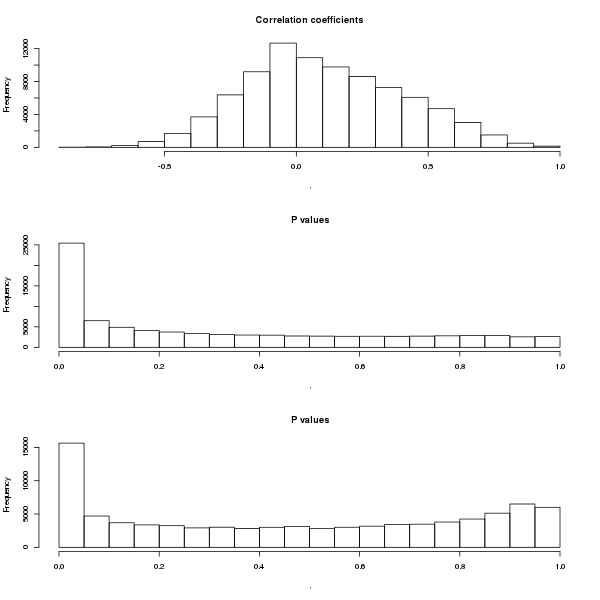

In [10]:
%%R -h 600 -w 600
par(mfrow=c(3,1))
l2fc.pear$r %>% as.dist %>% as.vector %>% hist(main='Correlation coefficients')
l2fc.pear$p %>% as.dist %>% as.vector %>% hist(main='P values')
l2fc.pear$p %>% t %>% as.dist %>% as.vector %>% hist(main='P values')

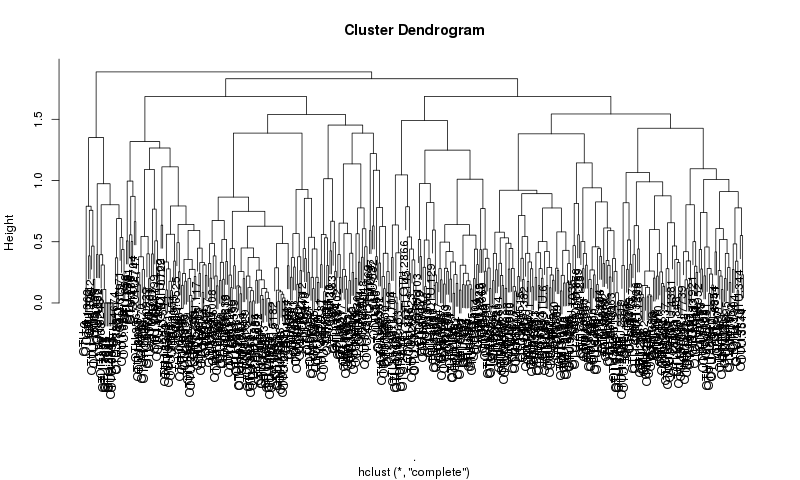

In [11]:
%%R -w 800
# making correlation distance transformation
dist.l2fc.pear = l2fc.pear$r %>% as.dist
dist.l2fc.pear = 1 - dist.l2fc.pear
hc.l2fc.pear = dist.l2fc.pear %>% hclust 
hc.l2fc.pear %>% plot

## Clustering

### PAM clustering

k with the max mean silho score: 2 


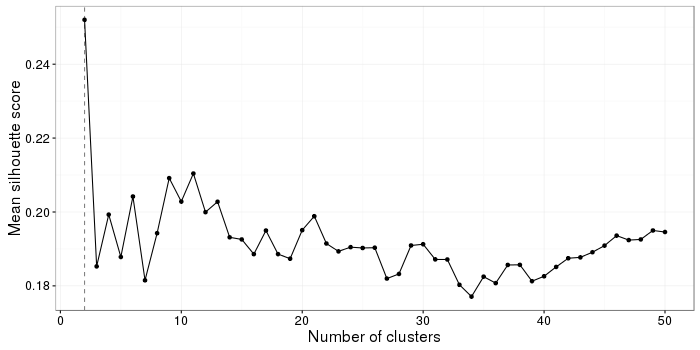

In [13]:
%%R -w 700 -h 350
# finding k with largest overall average silhouette width
ks = seq(2,50)

mean_silhouette = function(k, mtx){
    pam.res = pam(mtx, k, diss=TRUE)
    return(pam.res$silinfo$avg.width)
}

# calculating 
#dist.l2fc.pear = l2fc.pear %>% as.dist
#dist.l2fc.pear[dist.l2fc.pear < 0] = 0
mean_silho = sapply(ks, mean_silhouette, mtx=dist.l2fc.pear)
df.silho = data.frame('k' = ks, 'mean_silho' = mean_silho)

# k with max silho score
max.k = df.silho[df.silho$mean_silho == max(df.silho$mean_silho),'k'][1]
cat('k with the max mean silho score:', max.k, '\n')

# plotting
ggplot(df.silho, aes(k, mean_silho)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept=max.k, linetype='dashed', alpha=0.5) +
    labs(x='Number of clusters', y='Mean silhouette score') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### pvclust

* ID 'signifcant' clusters

Creating a temporary cluster...done:
socket cluster with 39 nodes on host ‘localhost’
Multiscale bootstrap... Done.


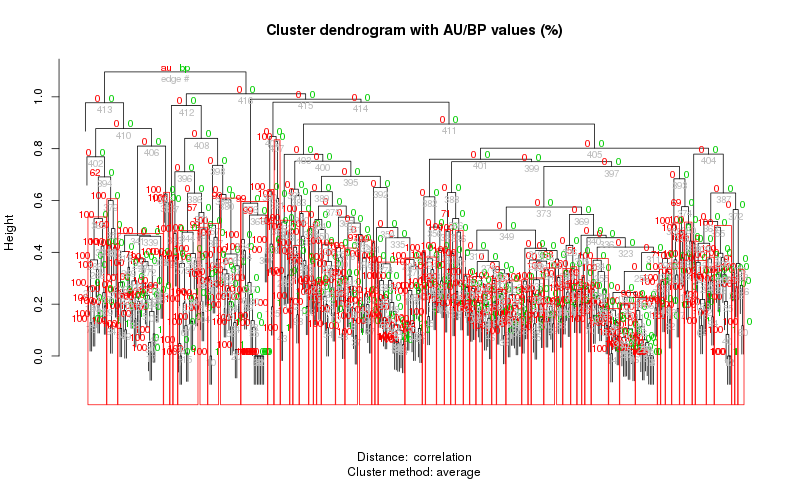

In [432]:
%%R -w 800 
pvc.res = pvclust::pvclust(df.l2fc.w %>% t, 
                           method.hclust='average', 
                           method.dist='correlation',
                           nboot=10000, parallel=TRUE)
plot(pvc.res, labels=FALSE)
pvclust::pvrect(pvc.res)

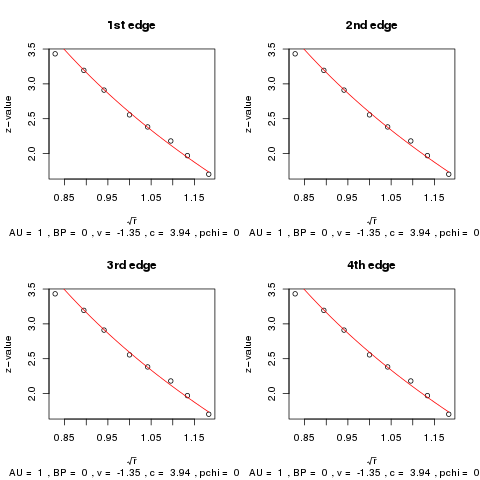

In [827]:
%%R
pvclust::msplot(pvc.res, edges=c(1,2,3,4))

In [828]:
%%R
# number of significant clusters
pvc.clusts = pvclust::pvpick(pvc.res)
pvc.clusts$clusters %>% length

[1] 68


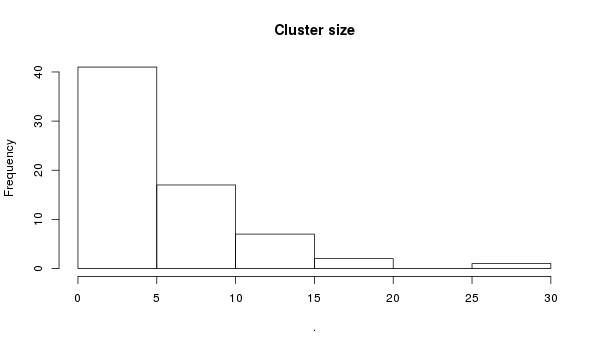

In [829]:
%%R -w 600 -h 350
# size of each cluster
do.call(rbind, lapply(pvc.clusts$clusters, length)) %>% 
    as.vector %>% 
    hist(binwidth=1, main='Cluster size')

In [870]:
%%R
# making dataframe of clusters

clusts = matrix(ncol=2)
for(i in 1:length(pvc.clusts$clusters)){
    x = pvc.clusts$clusters[[i]]
    x = x %>% as.matrix
    x = cbind(x, rep(i, nrow(x)))
    clusts = rbind(clusts, x)
}
df.pvc.clusts = clusts[2:nrow(clusts),] %>% as.data.frame
colnames(df.pvc.clusts) = c('OTU', 'pvc.cluster.ID')
df.pvc.clusts %>% head

        OTU pvc.cluster.ID
1 OTU.10707              1
2  OTU.1073              1
3 OTU.13481              1
4  OTU.2125              1
5  OTU.3812              1
6  OTU.7961              1


## formatting and filtering

In [848]:
%%R
# long table of coefficients
df.l2fc.pear = dist.l2fc.pear %>% as.matrix %>% as.data.frame
df.l2fc.pear$OTU_A = rownames(df.l2fc.pear)
df.l2fc.pear = df.l2fc.pear %>% 
    gather(OTU_B, coef.dist, starts_with('OTU.')) 
df.l2fc.pear %>% head

      OTU_A OTU_B coef.dist
1     OTU.1 OTU.1 0.0000000
2 OTU.10019 OTU.1 1.1748645
3  OTU.1002 OTU.1 1.0479462
4  OTU.1004 OTU.1 0.8480531
5  OTU.1008 OTU.1 0.9862609
6  OTU.1016 OTU.1 0.7440364


In [849]:
%%R
# long table of adjusted p-values
## p-adjusted values are upper.tri

# making long table
df.l2fc.pear.p = l2fc.pear$p %>% t %>% as.dist %>% as.matrix %>% as.data.frame
df.l2fc.pear.p$OTU_A = rownames(df.l2fc.pear.p)
df.l2fc.pear.p = df.l2fc.pear.p %>% 
    gather(OTU_B, p.adj, starts_with('OTU.')) 
df.l2fc.pear.p %>% head

      OTU_A OTU_B     p.adj
1     OTU.1 OTU.1 0.0000000
2 OTU.10019 OTU.1 0.5607236
3  OTU.1002 OTU.1 0.9068986
4  OTU.1004 OTU.1 0.6289538
5  OTU.1008 OTU.1 0.9734168
6  OTU.1016 OTU.1 0.3359395


In [850]:
%%R
# combining
df.l2fc.pear %>% nrow %>% print
df.l2fc.pear = inner_join(df.l2fc.pear, df.l2fc.pear.p, c('OTU_A' = 'OTU_A',
                                                          'OTU_B' = 'OTU_B')) 
df.l2fc.pear %>% nrow %>% print
df.l2fc.pear %>% head(n=3)

[1] 174724
[1] 174724
      OTU_A OTU_B coef.dist     p.adj
1     OTU.1 OTU.1  0.000000 0.0000000
2 OTU.10019 OTU.1  1.174864 0.5607236
3  OTU.1002 OTU.1  1.047946 0.9068986


In [851]:
%%R
# adding pvclusts
df.l2fc.pear %>% nrow %>% print
df.l2fc.pear.j = inner_join(df.l2fc.pear, df.pvc.clusts, c('OTU_A' = 'OTU'))
df.l2fc.pear.j = inner_join(df.l2fc.pear.j, df.pvc.clusts, c('OTU_B' = 'OTU'))         
df.l2fc.pear.j %>% nrow %>% print

df.l2fc.pear.j %>% head

[1] 174724
[1] 169744
      OTU_A OTU_B coef.dist     p.adj pvc.cluster.ID.x pvc.cluster.ID.y
1     OTU.1 OTU.1 0.0000000 0.0000000               59               59
2 OTU.10019 OTU.1 1.1748645 0.5607236               19               59
3  OTU.1002 OTU.1 1.0479462 0.9068986               32               59
4  OTU.1004 OTU.1 0.8480531 0.6289538               23               59
5  OTU.1008 OTU.1 0.9862609 0.9734168               25               59
6  OTU.1016 OTU.1 0.7440364 0.3359395               43               59


# Plotting networks

## Making incorporator value list

In [852]:
%%R
# making a list of incorporator substrates for each OTU

OTUs = df.l2fc.pear.f %>% 
    select(OTU_A, OTU_B) %>% 
    as.data.frame %>% as.matrix %>%
    as.vector %>% unique
OTUs %>% length %>% print

df.l2fc.inc = df.l2fc %>% 
    filter(Incorporator == 1,
           OTU %in% OTUs) %>%
    select(OTU, Substrate) %>%
    group_by(OTU) %>%
    nest(Substrate) 

# making list
pie.vals = list()
for(i in 1:nrow(df.l2fc.inc)){
    OTU = df.l2fc.inc[i,'OTU'] %>% as.matrix %>% as.vector
    tmp = df.l2fc.inc[i,'data'] %>% unnest 
    # converting to sums
    tmp = tmp$Substrate %>% as.numeric 
    l.tmp = length(tmp)
    tmp = rep(1/l.tmp, l.tmp)
    pie.vals[[OTU]] = tmp
}

pie.vals[[1]]

[1] 418
[1] 0.5 0.5


In [853]:
%%R
# making a list of incorporator substrates for each OTU
OTUs = df.l2fc.pear.f %>% 
    select(OTU_A, OTU_B) %>% 
    as.data.frame %>% as.matrix %>%
    as.vector %>% unique
OTUs %>% length %>% print

# getting fractions
df.l2fc.inc = df.l2fc %>% 
    filter(Incorporator == 1,
           OTU %in% OTUs) %>%
    select(OTU, Substrate) %>%
    distinct(OTU, Substrate) %>%
    mutate(X = 1) %>%
    spread(Substrate, X, fill=0)
rownames(df.l2fc.inc) = df.l2fc.inc$OTU
df.l2fc.inc$OTU = NULL


df.l2fc.inc %>% head(n=3)

[1] 418
          13C-Ami 13C-Cel 13C-Glu 13C-Gly 13C-Lac 13C-Oxa 13C-Pal 13C-Van
OTU.1           0       0       0       0       0       0       0       0
OTU.10019       0       1       0       0       0       0       0       0
OTU.1002        0       1       0       0       0       0       0       0
          13C-Xyl
OTU.1           1
OTU.10019       0
OTU.1002        0


## Making incorporator by day value list

* which days did we detect the incorporators

In [854]:
%%R
# getting incorporator by day dataframe
df.l2fc.incDay = df.l2fc %>% 
    filter(Incorporator == 1,
           OTU %in% OTUs) %>%
    select(OTU, Day) %>%
    distinct(OTU, Day) %>%
    mutate(X = 1) %>%
    spread(Day, X, fill=0)
rownames(df.l2fc.incDay) = df.l2fc.incDay$OTU
df.l2fc.incDay$OTU = NULL
   
df.l2fc.incDay %>% head

          1 3 6 14 30 48
OTU.1     0 1 0  1  0  0
OTU.10019 0 0 0  1  0  0
OTU.1002  0 0 0  0  1  0
OTU.1004  0 0 0  1  0  0
OTU.1008  0 0 0  0  1  1
OTU.1016  0 0 0  1  0  0


## Graph set

In [855]:
%%R -w 600 -h 350
# just significant correlations
coef.dist.cut = 0.2
p.cut = 0.01

df.l2fc.pear.f = df.l2fc.pear %>%
    filter(p.adj < p.cut,
           coef.dist < coef.dist.cut) %>%
    as.data.frame 

cat('Pre-filter:', df.l2fc.pear %>% nrow, '\n')
cat('Post-filter:', df.l2fc.pear.f %>% nrow, '\n\n')

df.l2fc.pear.f %>% head(n=3)

Pre-filter: 174724 
Post-filter: 1718 

      OTU_A     OTU_B coef.dist p.adj
1     OTU.1     OTU.1         0     0
2 OTU.10019 OTU.10019         0     0
3  OTU.1002  OTU.1002         0     0


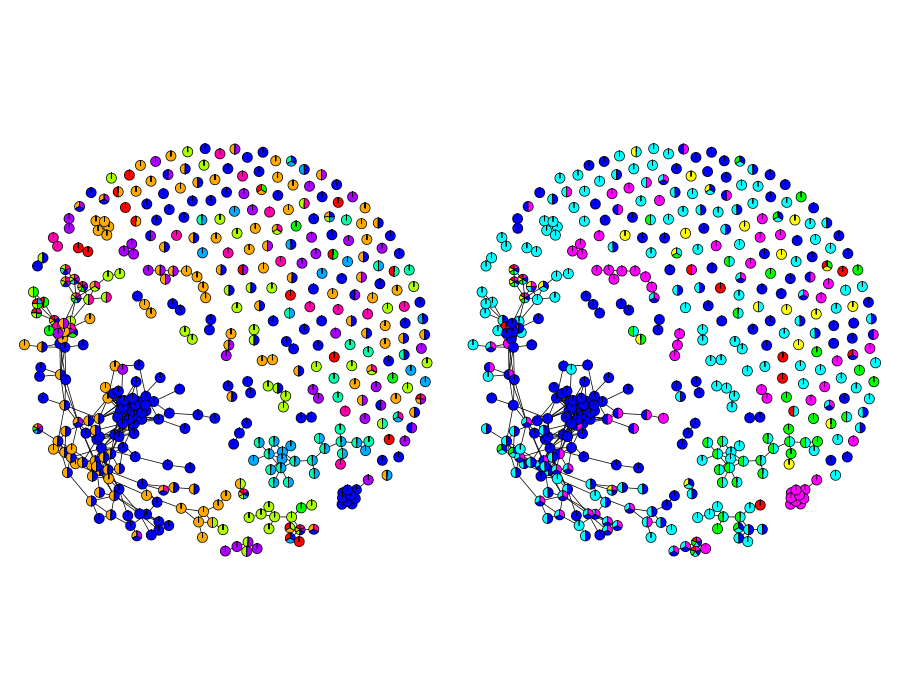

In [856]:
%%R -w 900 -h 700

# making graph
g = graph_from_data_frame(df.l2fc.pear.f, directed=FALSE)

# edit graph
g = simplify(g)
coords = layout_with_fr(g, niter=1000)

# multi-plot
par(mfrow=c(1,2),
    oma=c(0,0,0,0) + 0.1,
    mar=c(0,0,0,0) + 0.1)


# plotting; color by substrate
pie.cols = list(rainbow(9))
pie.vals = df.l2fc.inc[V(g)$name,] %>% t %>% as.matrix %>% as.data.frame 
#pie.shapes = apply(pie.vals, 2, function(x) ifelse(sum(x) == 1, 'circle', 'pie')) %>% as.vector
plot(g, 
     layout=coords, 
     edge.color='black',
     vertex.shape='pie',
     #vertex.shape=pie.shapes,   
     vertex.size=5, 
     vertex.label='',
     vertex.pie=pie.vals, 
     vertex.pie.color=pie.cols)


# plotting; color by day
pie.cols = list(rainbow(6))
pie.vals = df.l2fc.incDay[V(g)$name,] %>% t %>% as.matrix %>% as.data.frame 
#pie.shapes = apply(pie.vals, 2, function(x) ifelse(sum(x) == 1, 'circle', 'pie')) %>% as.vector
plot(g, 
     layout=coords, 
     edge.color='black',
     vertex.shape='pie',
     #vertex.shape=pie.shapes,   
     vertex.size=5, 
     vertex.label='',
     vertex.pie=pie.vals, 
     vertex.pie.color=pie.cols)

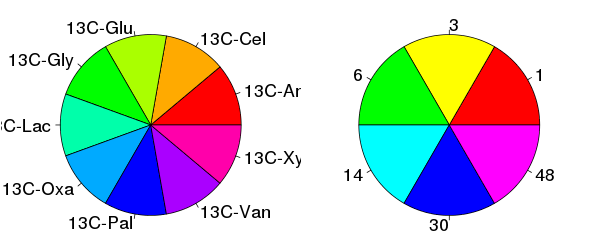

In [857]:
%%R -w 600 -h 250
par(mfrow=c(1,2),
    oma=c(0,0,0,0) + 0.1,
    mar=c(0,0,0,0) + 0.1)
pie(rep(1,9), labels=colnames(df.l2fc.inc), col=rainbow(9), cex=1.5)
pie(rep(1,6), labels=colnames(df.l2fc.incDay), col=rainbow(6), cex=1.5)

## Network based on pvclust significant clusters

In [859]:
%%R -w 600 -h 350
# pvclust significant clusters

df.l2fc.pear.f = df.l2fc.pear.j %>%
    filter(pvc.cluster.ID.x == pvc.cluster.ID.y) 

cat('Pre-filter:', df.l2fc.pear %>% nrow, '\n')
cat('Post-filter:', df.l2fc.pear.f %>% nrow, '\n\n')

df.l2fc.pear.f %>% head(n=3)

Pre-filter: 174724 
Post-filter: 3926 

     OTU_A OTU_B coef.dist      p.adj pvc.cluster.ID.x pvc.cluster.ID.y
1    OTU.1 OTU.1 0.0000000 0.00000000               59               59
2 OTU.1427 OTU.1 0.5398344 0.03440223               59               59
3   OTU.34 OTU.1 0.4475531 0.00651032               59               59


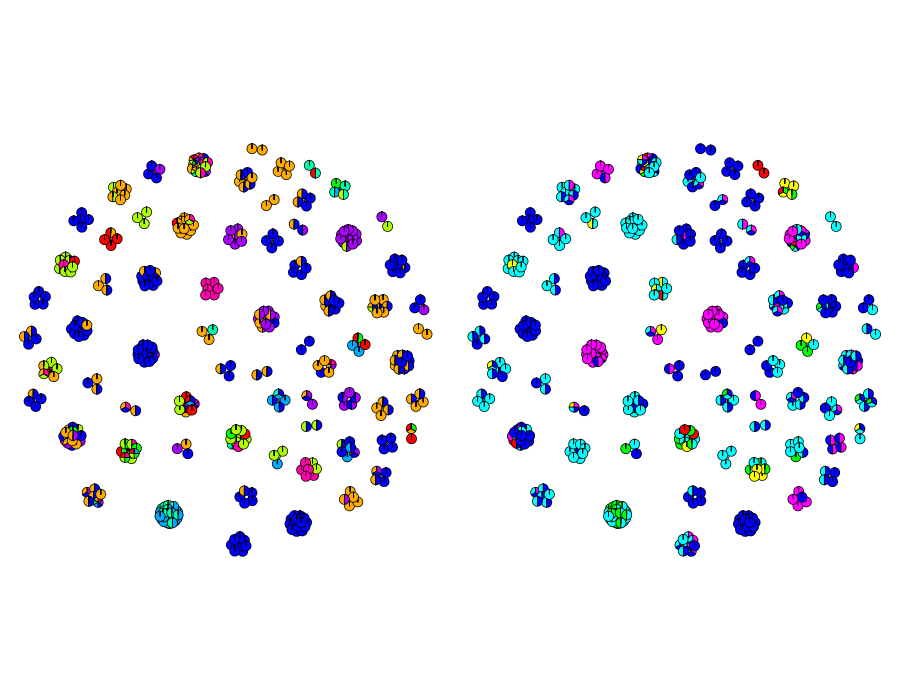

In [860]:
%%R -w 900 -h 700

# making graph
g = graph_from_data_frame(df.l2fc.pear.f, directed=FALSE)

# edit graph
g = simplify(g)
coords = layout_with_fr(g, niter=1000)

# multi-plot
par(mfrow=c(1,2),
    oma=c(0,0,0,0) + 0.1,
    mar=c(0,0,0,0) + 0.1)


# plotting; color by substrate
pie.cols = list(rainbow(9))
pie.vals = df.l2fc.inc[V(g)$name,] %>% t %>% as.matrix %>% as.data.frame 
#pie.shapes = apply(pie.vals, 2, function(x) ifelse(sum(x) == 1, 'circle', 'pie')) %>% as.vector
plot(g, 
     layout=coords, 
     edge.color='black',
     vertex.shape='pie',
     #vertex.shape=pie.shapes,   
     vertex.size=5, 
     vertex.label='',
     vertex.pie=pie.vals, 
     vertex.pie.color=pie.cols)


# plotting; color by day
pie.cols = list(rainbow(6))
pie.vals = df.l2fc.incDay[V(g)$name,] %>% t %>% as.matrix %>% as.data.frame 
#pie.shapes = apply(pie.vals, 2, function(x) ifelse(sum(x) == 1, 'circle', 'pie')) %>% as.vector
plot(g, 
     layout=coords, 
     edge.color='black',
     vertex.shape='pie',
     #vertex.shape=pie.shapes,   
     vertex.size=5, 
     vertex.label='',
     vertex.pie=pie.vals, 
     vertex.pie.color=pie.cols)

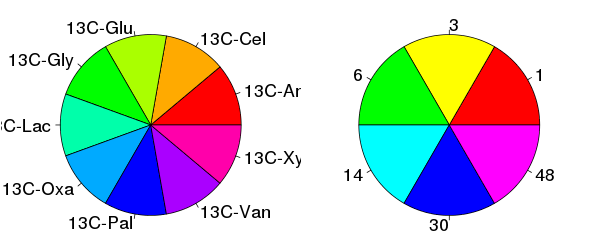

In [861]:
%%R -w 600 -h 250
par(mfrow=c(1,2),
    oma=c(0,0,0,0) + 0.1,
    mar=c(0,0,0,0) + 0.1)
pie(rep(1,9), labels=colnames(df.l2fc.inc), col=rainbow(9), cex=1.5)
pie(rep(1,6), labels=colnames(df.l2fc.incDay), col=rainbow(6), cex=1.5)

# Plotting l2fc dynamics for each pvclust clust

In [862]:
%%R

df.l2fc.pvc = inner_join(df.pvc.clusts, df.l2fc, c('OTU' = 'OTU'))

df.l2fc.pvc.s = df.l2fc.pvc %>%
    group_by(Substrate, Day, pvc.cluster.ID) %>%
    summarize(median_l2fc = median(log2FoldChange)) %>%
    ungroup() %>%
    complete(Substrate, Day, pvc.cluster.ID) %>%
    mutate(median_l2fc = ifelse(is.na(median_l2fc), 0, median_l2fc))



# majority rule
maj.rule = function(x){
    y = x %>% table %>% sort(decreasing=TRUE) %>% names
    y[1] 
}
df.maj.rule = df.l2fc.pvc %>% 
    filter(Incorporator == 1) %>%
    group_by(pvc.cluster.ID) %>%
    summarize(Day.maj.rule = maj.rule(Day),
              Sub.maj.rule = maj.rule(Substrate)) %>%
    ungroup() %>%
    unite(maj.rule, Day.maj.rule, Sub.maj.rule, sep='_', remove=FALSE) %>%
    mutate(maj.rule = gsub('^', 'D', maj.rule))

df.l2fc.pvc.s = inner_join(df.l2fc.pvc.s, df.maj.rule, c('pvc.cluster.ID' = 'pvc.cluster.ID')) 


df.l2fc.pvc.s$pvc.cluster.ID = reorder(df.l2fc.pvc.s$pvc.cluster.ID, 
                                       df.l2fc.pvc.s$pvc.cluster.ID %>% as.numeric)

df.l2fc.pvc.s %>% head

Source: local data frame [6 x 7]

  Substrate   Day pvc.cluster.ID median_l2fc    maj.rule Day.maj.rule
     (fctr) (int)         (fctr)       (dbl)       (chr)        (chr)
1   13C-Ami     1              1  0.00000000 D30_13C-Pal           30
2   13C-Ami     1             10  0.43282265 D30_13C-Cel           30
3   13C-Ami     1             11  0.00000000 D30_13C-Cel           30
4   13C-Ami     1             12 -0.25962597 D30_13C-Pal           30
5   13C-Ami     1             13 -1.38840076 D30_13C-Pal           30
6   13C-Ami     1             14 -0.04824186 D30_13C-Pal           30
Variables not shown: Sub.maj.rule (chr)


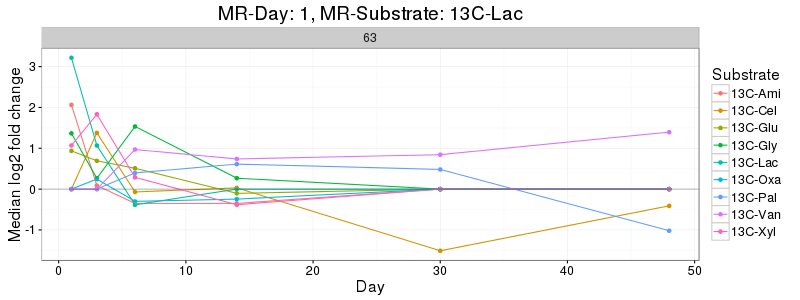

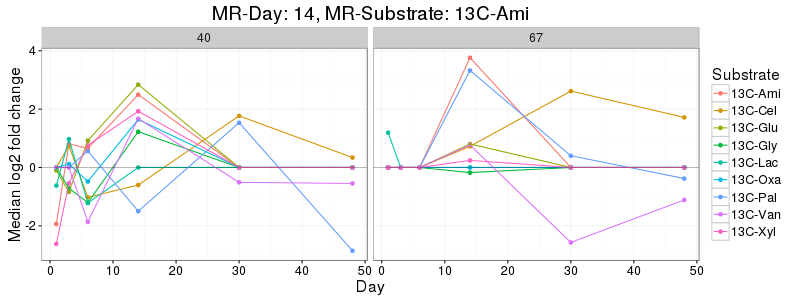

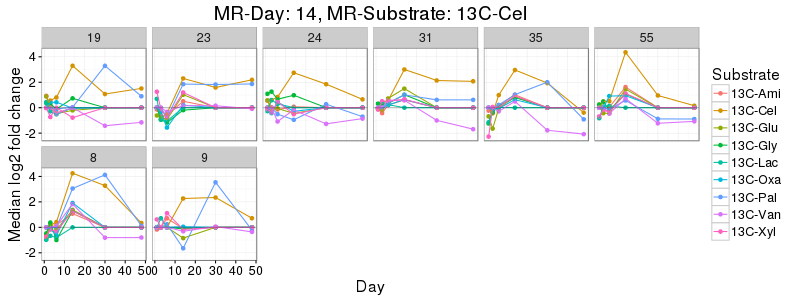

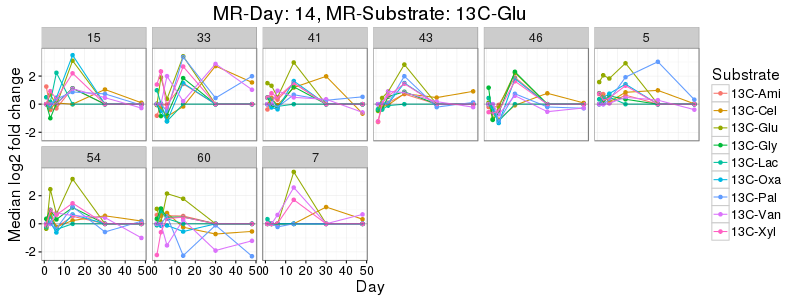

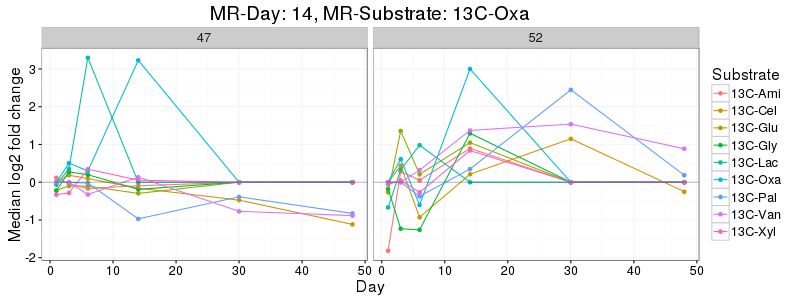

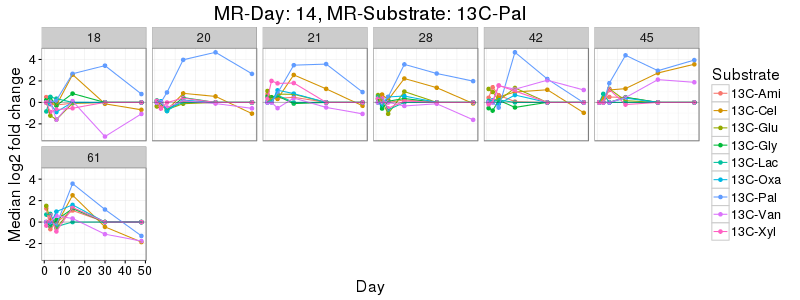

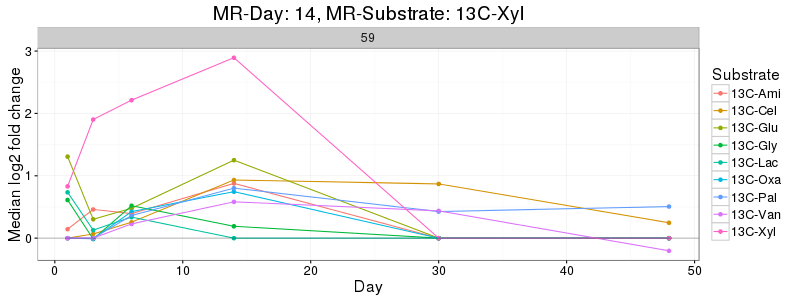

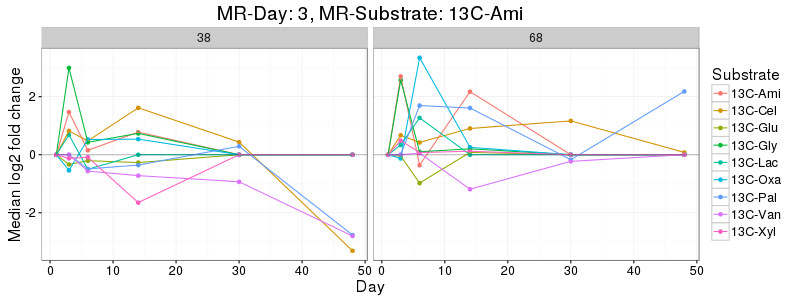

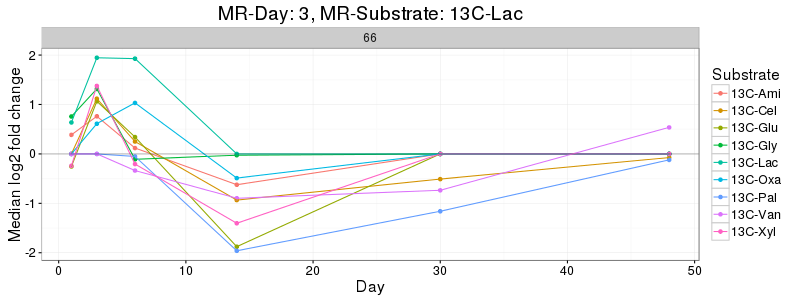

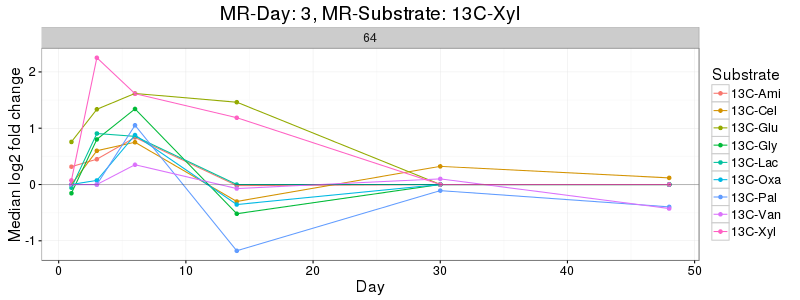

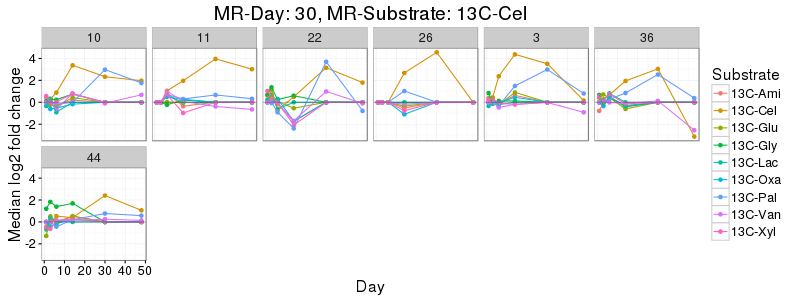

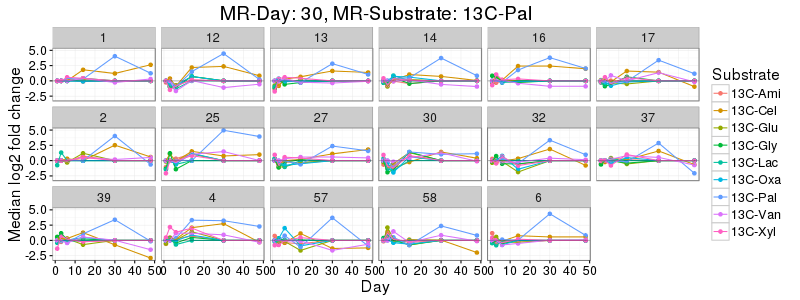

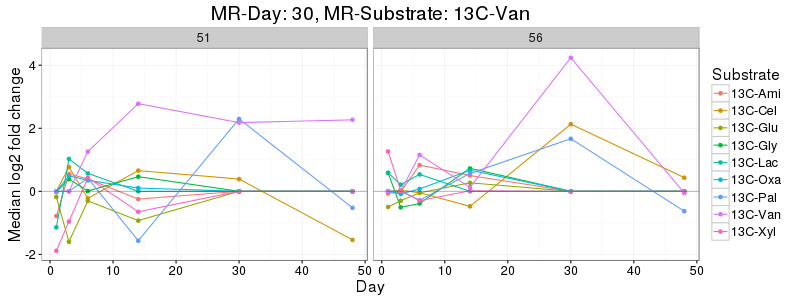

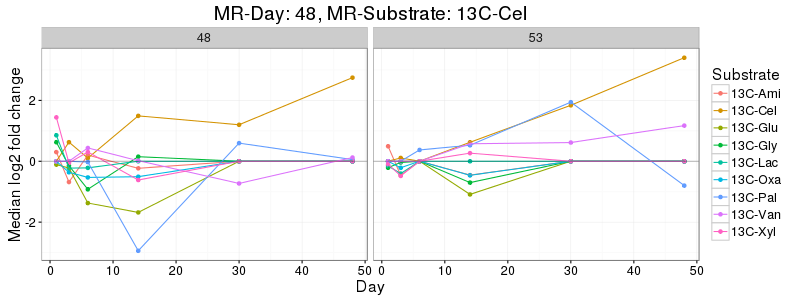

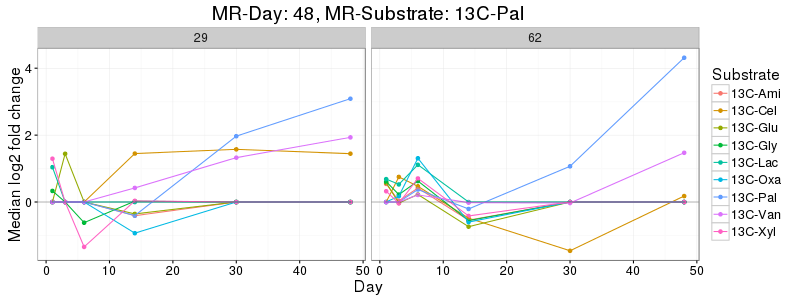

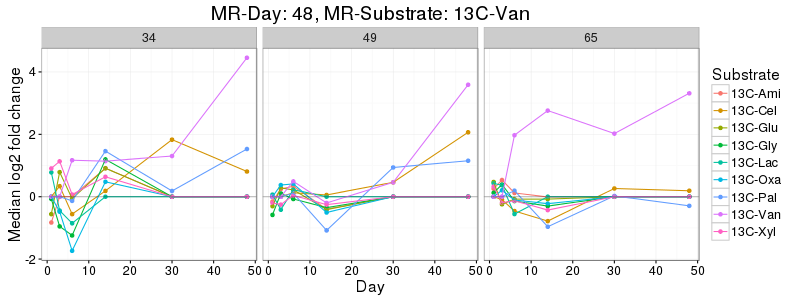

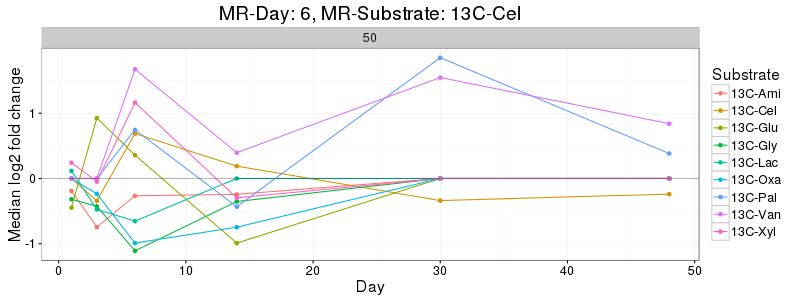

In [863]:
%%R -w 800 -h 300

make.plot = function(df, Day){
    Day.maj.rule = df$Day.maj.rule2 %>% unique
    Sub.maj.rule = df$Sub.maj.rule2 %>% unique
    title = paste0('MR-Day: ', Day.maj.rule, ', MR-Substrate: ', Sub.maj.rule, collapse=' ')
    
    p = ggplot(df, aes(Day, median_l2fc, color=Substrate)) +
        geom_point() +
        geom_line() +
        geom_hline(yintercept=0, alpha=0.25) +
        labs(y='Median log2 fold change', title=title) +
        facet_wrap(~ pvc.cluster.ID, ncol=6) +
        theme_bw() +
        theme(
            text = element_text(size=16)
        )
    print(p)
    return(1)
}


df.l2fc.pvc.s.p = df.l2fc.pvc.s %>% 
    mutate(Day.maj.rule2 = Day.maj.rule, 
           Sub.maj.rule2 = Sub.maj.rule) %>%
    group_by(Day.maj.rule, Sub.maj.rule) %>%
    nest %>%
    mutate(plot = lapply(data, make.plot, Day = Day.maj.rule))

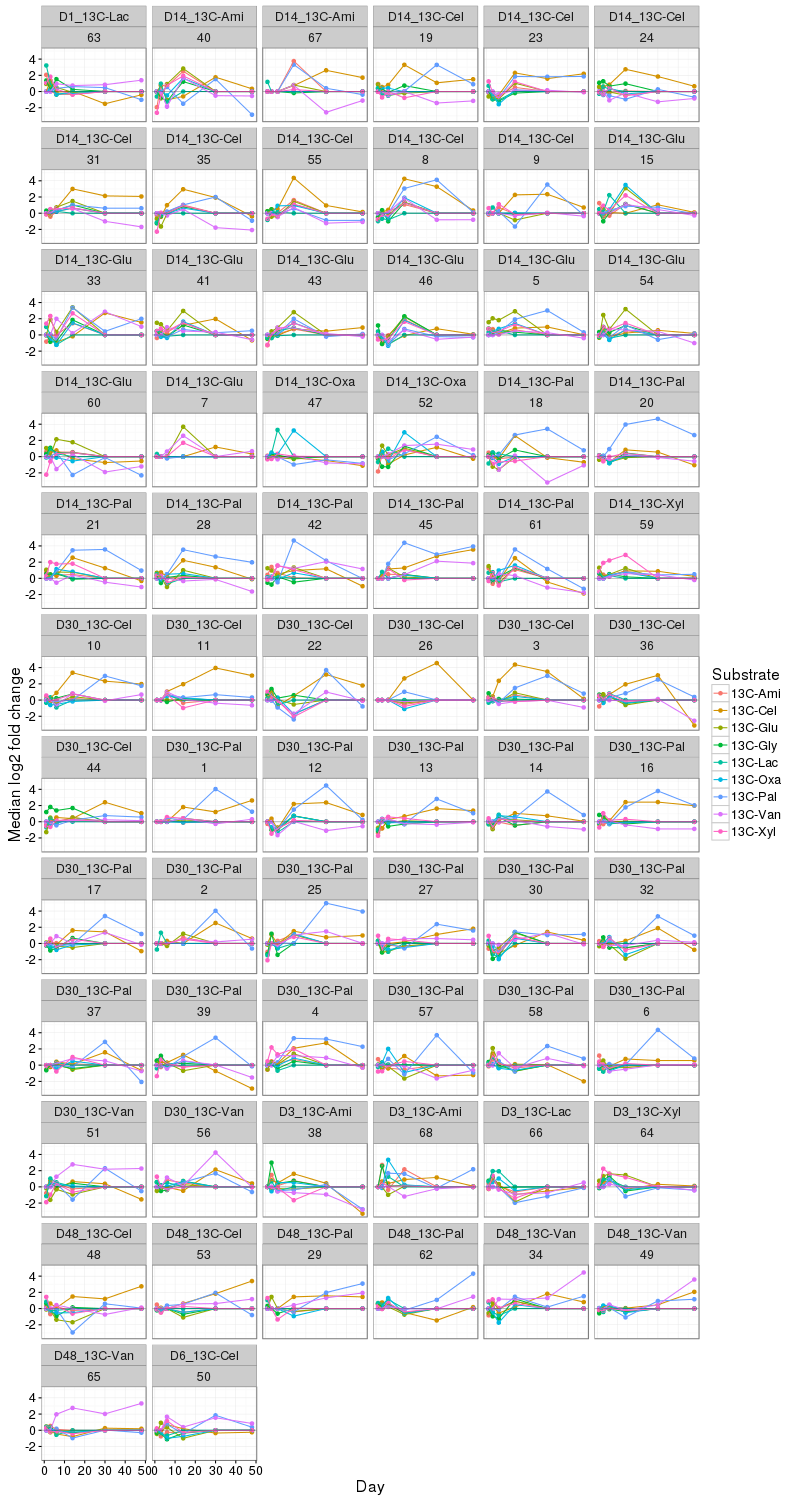

In [864]:
%%R -w 800 -h 1500

ggplot(df.l2fc.pvc.s, aes(Day, median_l2fc, color=Substrate)) +
    geom_point() +
    geom_line() +
    geom_hline(yintercept=0, alpha=0.25) +
    labs(y='Median log2 fold change') +
    facet_wrap(maj.rule ~ pvc.cluster.ID, ncol=6) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )